# PyTorch: Autoencoder

We consider the communication system depicted in the problem assignement.

$A \in \{0,1,\dots ,7\}$ with uniform distribution, $X \in \mathcal{X}$ are symbol from a 8-ASK constellation and $Z$ is additive white Gaussian noise with power $\sigma^2 = 0.01$.
Tanh is a nonlinear function which distort the transmit signal, it simulates the effect of an amplifier.

An autoencoder is used instead of the mapper and demapper. 
This enables us to find an optimal constellation $\mathcal{X}$ tailor to this specific channel.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch            
from torch import nn, optim

Function that realizes the nonlinear function tanh and the additive noise.

In [2]:
# Channel 
def tanh_channel(x, sigma2, seed=None):
    noise_t = sigma2*torch.randn(len(x),1)
    return torch.tanh(x) + noise_t

Creating a dataset of $n=10 000$ samples of indices $a_i$, maping them into transmit symbols $x_i$ and transmitting them over the channel to obtain $y_i$.

In [6]:
# Data
# Alphabet
alphabet = np.array([-7., -5., -3., -1., 1., 3., 5., 7.])  # alphabet
alphabet = alphabet /  np.sqrt(np.mean(np.abs(alphabet**2)))  # normalization
n = 10_000  # number of samples
M = 8  # constellation size
sigma2 = 0.06  # noise power
# Indices
a = np.random.choice(range(M), size=n)
a_t = torch.tensor(a)
a_t = a_t.type(torch.LongTensor)
# Transmit symbols 
x = alphabet[a]
x_t = torch.tensor(x).float().reshape(-1,1)
# Received symbols
y_t = tanh_channel(x_t, sigma2)
y = y_t.detach().numpy()

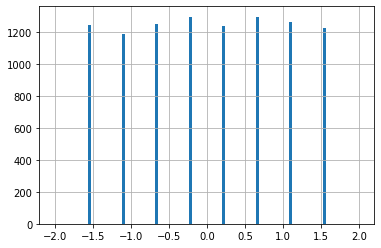

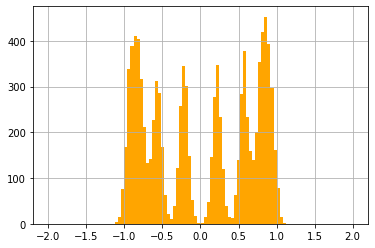

In [7]:
# Visualize your data
plt.hist(x, bins=100, range=[-2, 2])
plt.grid()
plt.show()
plt.hist(y, bins=100, range=[-2, 2], color = 'orange')
plt.grid()
plt.show()

Defining the neural network demapper. 
The demapper takes as input the real valued channel output  $y_i$ and returns an array of values which represents the log-probabilities that the current channel output belongs to each constellation symbol. Basically it does an s multi-class classification.

In [9]:
# Define a demapper Neural Network
class DemapperNN(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y 

Training the network using $a_i$ as labels and the cross entropy loss function.

In [10]:
# Initialize network
rx = DemapperNN(M)
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(rx.parameters(), lr=0.01)
# Epochs
num_epochs = 10_000

In [11]:
# Training loop
for j in range(num_epochs):
    # Receiver
    l = rx(y_t)
    # Loss
    loss = loss_fn(l, a_t)
    # Calculate gradient and weights update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 1000 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    if loss < 1e-3:
        break

epoch 0: Loss = 2.1414
epoch 1000: Loss = 1.1000
epoch 2000: Loss = 0.8898
epoch 3000: Loss = 0.7521
epoch 4000: Loss = 0.6466
epoch 5000: Loss = 0.5613
epoch 6000: Loss = 0.4916
epoch 7000: Loss = 0.4348
epoch 8000: Loss = 0.3892
epoch 9000: Loss = 0.3528


Hard decision on the output of your network using a new dataset and evaluating the SER.

In [12]:
# New Dataset
a_test = np.random.choice(range(M), size=n)
# Transmit symbols 
x_test = alphabet[a_test]
x_test_t = torch.tensor(x_test).float().reshape(-1,1)
# Received symbols
y_test_t = tanh_channel(x_test_t, sigma2)
# Demapper
l_test = rx(y_test_t)

In [13]:
# Hard decision
hd = np.argmax(l_test.detach().numpy(), axis=1)
print(f'SER: {sum((a_test!=hd)/a_test.size)}')

SER: 0.10250000000000191


Function that implements one-hot encoding.

In [14]:
def one_hot(a, M):
    onehot = np.zeros(M)
    onehot[a] = 1
    return onehot

Definition of second neural network for the mapper.
The mapper takes as input the one-hot representation of the message and output a real valued symbol to be transmitted over the channel.

In [15]:
# Mapper NN
class MapperNN(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)

    def forward(self, y):
        y = self.lin1(y)
        return y   

Training the mapper and demapper neural networks using the messages $a_i$ as labels and the cross entropy loss function.

In [16]:
# Data
onehot = np.array([one_hot(a[i], M) for i in range(n)])
onehot_t = torch.tensor(onehot).float()

In [17]:
# Initialize network
tx = MapperNN(M)
# Optimizer
optimizer = optim.Adam(list(tx.parameters()) + list(rx.parameters()), lr=0.01)

In [18]:
# Training loop
for j in range(num_epochs):
    # Transmitter
    x = tx(onehot_t)
    # Channel
    y = tanh_channel(x, sigma2).float()
    # Receiver
    l = rx(y)
    # Loss
    loss = loss_fn(l, a_t)
    # Calculate gradient and weights update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 1000 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    if loss < 1e-3:
        break

epoch 0: Loss = 22.7629
epoch 1000: Loss = 0.2492
epoch 2000: Loss = 0.2092
epoch 3000: Loss = 0.1884
epoch 4000: Loss = 0.1743
epoch 5000: Loss = 0.1601
epoch 6000: Loss = 0.1463
epoch 7000: Loss = 0.1288
epoch 8000: Loss = 0.1168
epoch 9000: Loss = 0.1035


Plotting results and evaluating the SER.

In [19]:
# Data for the plots
a_plot = np.arange(M)
onehot_plot = np.array([one_hot(a_plot[i], M) for i in range(M)])
learned_x = tx(torch.tensor(onehot_plot).float())
yy_plot = torch.tanh(learned_x)

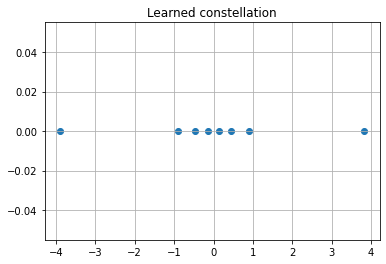

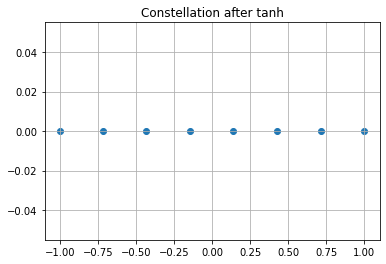

In [20]:
# Plot the learned constellation before and after a tanh function
plt.scatter(np.real(learned_x.detach().numpy()), np.imag(learned_x.detach().numpy()))
plt.title('Learned constellation')
plt.grid()
plt.show()
plt.scatter(np.real(yy_plot.detach().numpy()), np.imag(yy_plot.detach().numpy()))
plt.title('Constellation after tanh')
plt.grid()

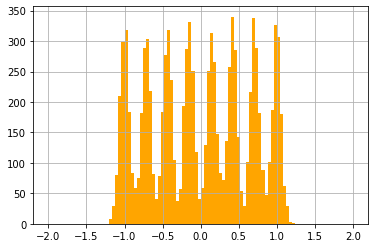

In [21]:
# Histogram of the received symbols
plt.hist(y.detach().numpy(), bins=100, range=[-2, 2], color = 'orange')
plt.grid()
plt.show()

In [22]:
# New Dataset
onehot_test = np.array([one_hot(a_test[i], M) for i in range(n)])
# Transmitter
x_test = tx(torch.tensor(onehot_test).float())
# Channel
y_test = tanh_channel(x_test, sigma2).float()
# Receiver
l_test = rx(y_test)
# Hard decision
hd = np.argmax(l_test.detach().numpy(), axis=1)

In [23]:
print(f'SER: {sum((a_test!=hd)/a_test.size)}')

SER: 0.01739999999999995
